# Libraries and setup

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model
from matplotlib.patches import Rectangle
import segmentation_models_pytorch as smp


**Reproducibility**

In [3]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(seed=42)

In [4]:
print(f"\n... ACCELERATOR SETUP STARTING ...\n")

try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU = None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()}...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    strategy = tf.distribute.get_strategy() 

N_REPLICAS = strategy.num_replicas_in_sync
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")
print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")


... ACCELERATOR SETUP STARTING ...


... RUNNING ON CPU/GPU ...
... # OF REPLICAS: 1 ...


... ACCELERATOR SETUP COMPLTED ...



**Config**

In [5]:
BATCH_SIZE = 16
EPOCHS = 25
n_splits = 5
fold_selected = 2   
IMAGE_WIDTH = 288
IMAGE_HEIGHT = 288

# Data

In [6]:
print("\n... DATA ACCESS SETUP STARTED ...\n")

DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
save_locally = None
load_locally = None


... DATA ACCESS SETUP STARTED ...



**Train set**

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


**Test set**

In [8]:
TEST_CSV = os.path.join(DATA_DIR, 'sample_submission.csv')
test_df = pd.read_csv(TEST_CSV)

if len(test_df)==0:
    DEBUG=True
    test_df = train_df[115488-300:]
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

,id,class,segmentation
115188,case30_day0_slice_0045,large_bowel,NaN
115189,case30_day0_slice_0045,small_bowel,NaN
115190,case30_day0_slice_0045,stomach,NaN
115191,case30_day0_slice_0046,large_bowel,NaN
115192,case30_day0_slice_0046,small_bowel,NaN


# Preprocessing

In [9]:
def preprocessing(df, subset="train", DEBUG=False):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    if subset == "train" or DEBUG:
        DIR = "../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR = "../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = [os.path.join(x, f"case{df['case'].values[i]}", 
                                       f"case{df['case'].values[i]}_day{df['day'].values[i]}", 
                                       "scans", 
                                       f"slice_{df['slice'].values[i]}") 
                         for i in range(df.shape[0])]
    
    df["path_partial"] = path_partial_list

    path_partial_list = [str(image.rsplit("_", 4)[0]) for image in all_images]

    tmp_df = pd.DataFrame({"path_partial": path_partial_list, "path": all_images})

    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))
    
    del x, path_partial_list, tmp_df
    
    return df


In [10]:
def restructure(df, subset="train"):
    # Restructure DataFrame
    df_out = pd.DataFrame({'id': df['id'][::3]})
    
    if subset == "train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out = df_out.reset_index(drop=True)
    df_out = df_out.fillna('')

    if subset == "train":
        df_out['count'] = np.sum(df_out.iloc[:, 1:4] != '', axis=1).values
    
    return df_out


In [11]:
train_df = preprocessing(train_df[:115488-300], subset="train")
print(train_df.shape)
train_df.head()

(115188, 9)


,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [12]:
test_df=preprocessing(test_df, subset="test")
print(test_df.shape)
test_df.head()

(300, 9)


,id,class,segmentation,case,day,slice,path,width,height
0,case30_day0_slice_0045,large_bowel,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case30_day0_slice_0045,small_bowel,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case30_day0_slice_0045,stomach,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case30_day0_slice_0046,large_bowel,NaN,30,0,0046,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case30_day0_slice_0046,small_bowel,NaN,30,0,0046,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [13]:
train_df=restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0


In [14]:
test_df=restructure(test_df, subset="train")
test_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case30_day0_slice_0045,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0045,266,266,0
1,case30_day0_slice_0046,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0046,266,266,0
2,case30_day0_slice_0047,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0047,266,266,0
3,case30_day0_slice_0048,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0048,266,266,0
4,case30_day0_slice_0049,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0049,266,266,0


In [15]:
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [16]:
# Garbage collection
gc.collect()

46

In [17]:
print(train_df.shape, test_df.shape)

(38108, 11) (100, 11)


# Helper functions

In [18]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.array(mask_rle.split(), dtype=int)   
    starts = s[0::2] - 1  # Every even value is the start, every odd value is the "run" length
    lengths = s[1::2]
    ends = starts + lengths

    if len(shape) == 3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = color    
    return img.reshape(shape)

In [19]:

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(map(str, runs))


In [20]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    true_positives = K.sum(y_true_f * y_pred_f)
    false_negatives = K.sum(y_true_f * (1 - y_pred_f))
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    tversky_coef = (true_positives + smooth) / (true_positives + alpha * false_negatives + beta * false_positives + smooth)
    return 1 - tversky_coef

def bce_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + tversky_loss(tf.cast(y_true, tf.float32), y_pred, alpha, beta)

In [21]:
def tversky(y_true, y_pred):
    smooth = 1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [22]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, subset="train", shuffle=False, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.width = width
        self.height = height
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, self.width, self.height, 3))
        y = np.empty((self.batch_size, self.width, self.height, 3))
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w = self.df['width'].iloc[indexes[i]]
            h = self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] = img  
            if self.subset == 'train':
                for k, j in enumerate(["large_bowel", "small_bowel", "stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (self.width, self.height))
                    y[i, :, :, k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        img = ((img - img.min()) / (img.max() - img.min())).astype(np.float32)
        img = np.expand_dims(img, axis=-1)
        return img


In [23]:
def scheduler(epoch, lr):
    if epoch < 18:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Cross-validation

In [27]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    8208
2    7036
3    7392
4    8704
5    6768
dtype: int64

In [28]:
# Fold sizes
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4803
      1         494
      2        2218
      3         693
2     0        4086
      1         352
      2        1972
      3         626
3     0        4164
      1         552
      2        2105
      3         571
4     0        4748
      1         606
      2        2614
      3         736
5     0        3860
      1         451
      2        1928
      3         529
Name: id, dtype: int64

# Model

In [29]:
#Data generators 
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

In [30]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [31]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-llnkeqt3
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-llnkeqt3
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [32]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [33]:
from segmentation_models import PSPNet
from segmentation_models.utils import set_trainable

model = PSPNet(backbone_name='resnet18', input_shape= (288, 288, 3), classes=3, activation='sigmoid')
model.compile(optimizer='adam', loss=bce_tversky_loss, metrics=[dice_coef,iou_coef])

44933120/44920640 [==============================] - 0s 0us/step


# Training model

In [34]:
checkpoint = ModelCheckpoint(
    'PSPNet_model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

In [35]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/25
1942/1942 [==============================] - 571s 289ms/step - loss: 0.3405 - dice_coef: 0.6364 - iou_coef: 0.6071 - val_loss: 0.3988 - val_dice_coef: 0.7573 - val_iou_coef: 0.7500

Epoch 00001: val_loss improved from inf to 0.39880, saving model to PSPNet_model
Epoch 2/25
1942/1942 [==============================] - 255s 131ms/step - loss: 0.2279 - dice_coef: 0.7507 - iou_coef: 0.7564 - val_loss: 0.5684 - val_dice_coef: 0.7276 - val_iou_coef: 0.7483

Epoch 00002: val_loss did not improve from 0.39880
Epoch 3/25
1942/1942 [==============================] - 254s 131ms/step - loss: 0.1916 - dice_coef: 0.7890 - iou_coef: 0.7963 - val_loss: 0.4005 - val_dice_coef: 0.7513 - val_iou_coef: 0.7469

Epoch 00003: val_loss did not improve from 0.39880
Epoch 4/25
1942/1942 [==============================] - 246s 127ms/step - loss: 0.1712 - dice_coef: 0.8105 - iou_coef: 0.8147 - val_loss: 0.6321 - val_dice_coef: 0.5699 - val_iou_coef: 0.6753

Epoch 00004: val_loss did not improve from 0.

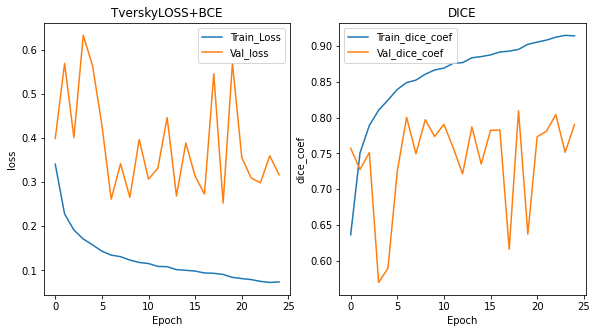

In [36]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('TverskyLOSS+BCE'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

# Evaluation

In [38]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_tversky_loss': bce_tversky_loss
}

model = load_model('./PSPNet_model', custom_objects=custom_objects)


**Preview predictions**

In [39]:
print(X_valid.shape)

(7036, 12)


In [40]:
pred_batches = DataGenerator(test_df, batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

100/100 [==============================] - 2s 15ms/step


In [41]:
model.evaluate(pred_batches)

100/100 [==============================] - 1s 8ms/step - loss: 0.6351 - dice_coef: 0.7778 - iou_coef: 0.7320


[0.635076642036438, 0.777819812297821, 0.7319520711898804]

In [ ]:
Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=10, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(10):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

In [43]:
testdf=test_df
testdf["segmentation"]=''
testdf=testdf.rename(columns={"segmentation":"predicted"})

pred_batches = DataGenerator(testdf, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)
submission1 = submission.copy()
for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches,verbose=0)

    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[i*BATCH_SIZE+j,:,:,k], (testdf.loc[i*BATCH_SIZE+j,"width"], testdf.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8') # classify
            submission.loc[115188 + 3*(i*BATCH_SIZE+j)+k,'segmentation'] = rle_encode(pred_img)
            submission1.iloc[3*(i*BATCH_SIZE+j)+k,2] = rle_encode(pred_img)
            submission1=submission1.rename(columns={"segmentation":"predicted"})

**Save predictions**

In [ ]:
submission1.to_csv('submission.csv',index=False)
submission1.sample(20)